In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sn
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix

In [2]:
!pip -q install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/competitions/aptos2019-blindness-detection/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anhnguyen14
Your Kaggle Key: ··········


100%|██████████| 9.51G/9.51G [02:17<00:00, 74.4MB/s]



Extracting archive ./aptos2019-blindness-detection/aptos2019-blindness-detection.zip to ./aptos2019-blindness-detection


In [3]:
data = pd.read_csv('/content/aptos2019-blindness-detection/train.csv')
data['id_code'] = '/content/aptos2019-blindness-detection/train_images/' + data['id_code']  +'.png'
data.head()

,id_code,diagnosis
0,/content/aptos2019-blindness-detection/train_i...,2
1,/content/aptos2019-blindness-detection/train_i...,4
2,/content/aptos2019-blindness-detection/train_i...,1
3,/content/aptos2019-blindness-detection/train_i...,0
4,/content/aptos2019-blindness-detection/train_i...,0


In [4]:
count = data.groupby(['diagnosis']).agg('count')
count

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


In [5]:
dist = pd.DataFrame({'classes': count.index.values, 'total': count.id_code.values})
dist

,classes,total
0,0,1805
1,1,370
2,2,999
3,3,193
4,4,295


<Axes: xlabel='classes', ylabel='total'>

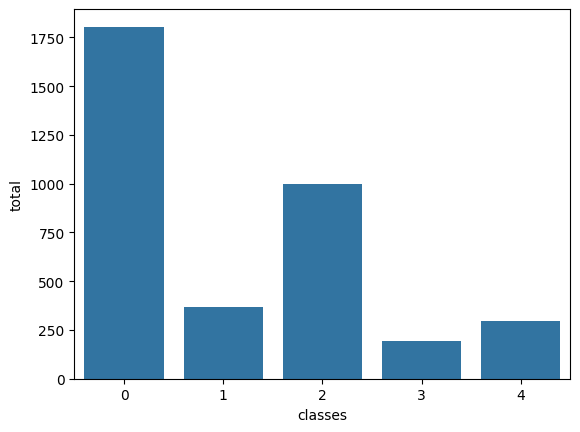

In [6]:
sn.barplot(dist, x='classes', y='total')

<BarContainer object of 5 artists>

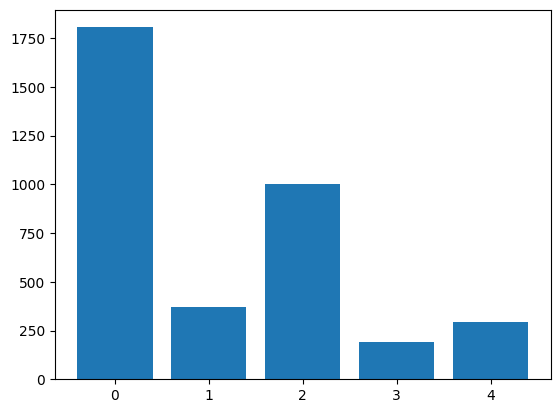

In [7]:
plt.bar(count.index, count.id_code)

In [8]:
count.index.values

array([0, 1, 2, 3, 4])

# Utils

In [9]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def process_img(img_path):
    img = cv2.imread(img_path)
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    return img

In [10]:
def plot_prediction(img_path, gt, pred):
    fig, axes = plt.subplots(4, 4, figsize=(7, 6))
    axes = axes.flatten()

    for i in range(len(axes)):

        img = process_img(img_path[i])
        axes[i].imshow(img)
        axes[i].axis("off")

        title_part1 = f"gt: {gt[i]}"
        title_part2 = f" | pred: {pred[i]}"

        if gt[i] == pred[i]:
            # Add the first part of the title to the second subplot
            axes[i].text(0.5, 1.05, title_part1, color='green', fontsize=10, ha='right', va='bottom', transform=axes[i].transAxes)

            # Add the second part of the title to the second subplot
            axes[i].text(0.5, 1.05, title_part2, color='green', fontsize=10, ha='left', va='bottom', transform=axes[i].transAxes)

        else:
            # Add the first part of the title to the second subplot
            axes[i].text(0.5, 1.05, title_part1, color='green', fontsize=10, ha='right', va='bottom', transform=axes[i].transAxes)

            # Add the second part of the title to the second subplot
            axes[i].text(0.5, 1.05, title_part2, color='red', fontsize=10, ha='left', va='bottom', transform=axes[i].transAxes)




In [11]:
from glob import glob
img_path = glob('/content/aptos2019-blindness-detection/train_images/*')[:8]
gt = [0, 1, 2, 3, 4, 2, 3, 0]
pred = [0, 1, 2, 3, 4, 2, 3, 2]


In [13]:
def convert_data(data):
  id_data, y, X = data.T
  X = np.array(X.tolist(), dtype=np.float64)
  y = np.array(y.tolist(), dtype=np.int64)
  return id_data, X, y


def load_data(train_path, test_path):
  train_data = np.load(train_path, allow_pickle=True)
  test_data = np.load(test_path, allow_pickle=True)

  return (
      convert_data(train_data),
      convert_data(test_data)
      )

class_names = [0, 1, 2, 3, 4]

In [14]:
def get_random_samples(gt, features, id):
    random_index = np.random.randint(0, len(gt), size=16)

    img_path = []
    folder = '/content/aptos2019-blindness-detection/train_images/'
    for i in id[random_index]:
        img_path.append(folder+i+'.png')

    return gt[random_index], features[random_index], img_path

In [15]:
(train_idn_gr, X_train_gr, y_trainn_gr), (test_idn_gr, X_testn_gr, y_testn_gr) = load_data('/content/drive/MyDrive/CS/datasets/histogram_grayscale/train_data.npy',
                                                                    '/content/drive/MyDrive/CS/datasets/histogram_grayscale/test_data.npy')

In [16]:
(train_idn_rgb, X_train_rgb, y_trainn_rgb), (test_idn_rgb, X_testn_rgb, y_testn_rgb) = load_data('/content/drive/MyDrive/CS/datasets/histogram_rgb/train_data.npy',
                                                                    '/content/drive/MyDrive/CS/datasets/histogram_rgb/test_data.npy')

# EfficientNet

In [17]:
train_data = np.load('/content/drive/MyDrive/CS/datasets/efficientnet_v2/train_data.npz')
test_data = np.load('/content/drive/MyDrive/CS/datasets/efficientnet_v2/test_data.npz')

train_id_ef, X_train_ef, y_train_ef = train_data['train_id'], train_data['train_features'], train_data['train_labels']
test_id_ef, X_test_ef, y_test_ef = test_data['test_id'], test_data['test_features'], test_data['test_labels']

## SVC

In [ ]:
from sklearn.svm import SVC

svc = SVC(C=10, gamma= 'scale', kernel= 'rbf')
svc.fit(X_train_ef, y_train_ef)

SVC(C=10)

In [ ]:
preds = svc.predict(X_test_ef)
print(classification_report(y_test_ef, preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       540
           1       0.63      0.58      0.61        98
           2       0.71      0.85      0.77       302
           3       0.45      0.36      0.40        55
           4       0.74      0.40      0.52       104

    accuracy                           0.82      1099
   macro avg       0.70      0.64      0.66      1099
weighted avg       0.82      0.82      0.82      1099



<Axes: >

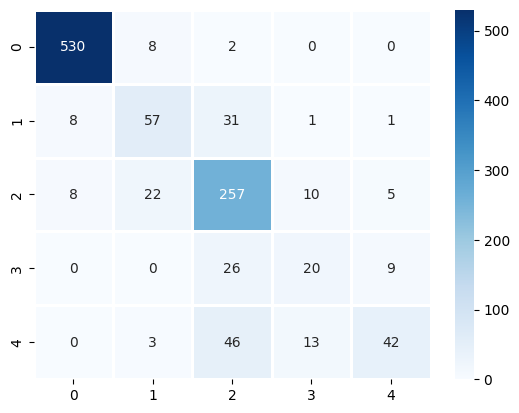

In [ ]:
sn.heatmap(confusion_matrix(y_test_ef, preds), cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')

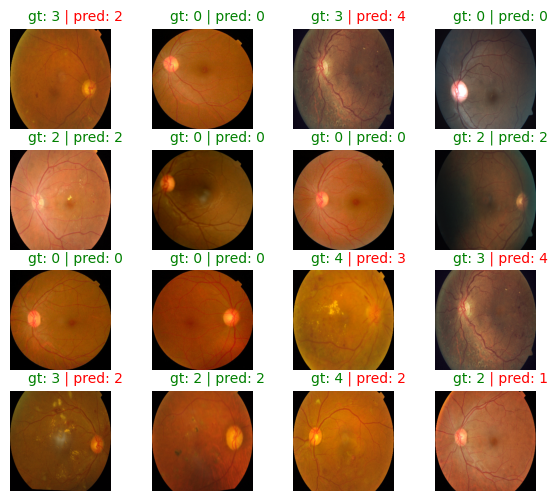

In [ ]:
gt, feat, id = get_random_samples(y_test_ef, X_test_ef, test_id_ef)

pred_ = svc.predict(feat)

plot_prediction(id, gt, pred_)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rft = RandomForestClassifier(criterion= 'log_loss', max_depth= None, max_features= None, n_estimators= 30)
rft.fit(X_train_ef, y_train_ef)

RandomForestClassifier(criterion='log_loss', max_features=None, n_estimators=30)

In [ ]:
preds = rft.predict(X_test_ef)
print(classification_report(y_test_ef, preds))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       540
           1       0.55      0.28      0.37        98
           2       0.61      0.86      0.72       302
           3       0.25      0.09      0.13        55
           4       0.74      0.22      0.34       104

    accuracy                           0.77      1099
   macro avg       0.62      0.49      0.50      1099
weighted avg       0.76      0.77      0.74      1099



<Axes: >

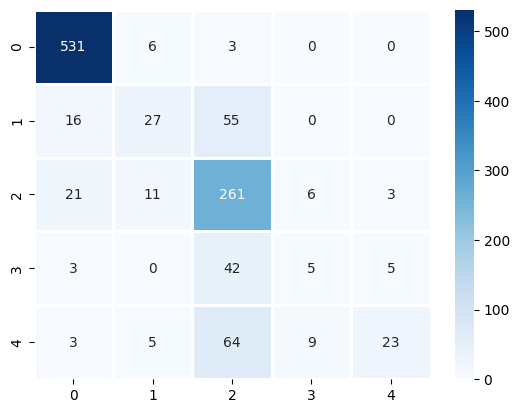

In [ ]:
sn.heatmap(confusion_matrix(y_test_ef, preds), cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')

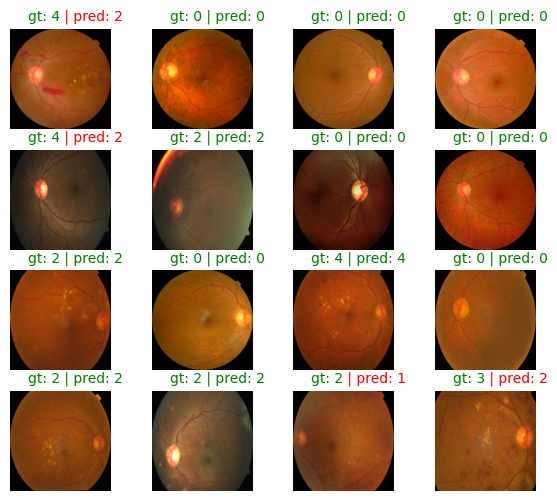

In [ ]:
gt, feat, id = get_random_samples(y_test_ef, X_test_ef, test_id_ef)

pred_ = rft.predict(feat)

plot_prediction(id, gt, pred_)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dct = DecisionTreeClassifier(criterion='log_loss', max_depth= 5, max_features= None, splitter= 'random')

dct.fit(X_train_ef, y_train_ef)

DecisionTreeClassifier(criterion='log_loss', max_depth=5, splitter='random')

In [ ]:
preds = rft.predict(X_test_ef)
print(classification_report(y_test_ef, preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       540
           1       0.69      0.24      0.36        98
           2       0.60      0.91      0.72       302
           3       0.36      0.07      0.12        55
           4       0.75      0.17      0.28       104

    accuracy                           0.78      1099
   macro avg       0.67      0.48      0.49      1099
weighted avg       0.78      0.78      0.74      1099



<Axes: >

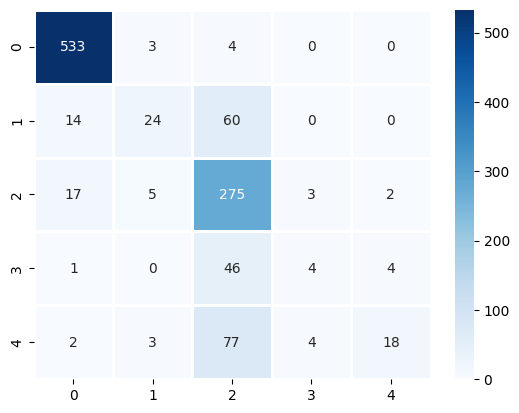

In [ ]:
sn.heatmap(confusion_matrix(y_test_ef, preds), cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')

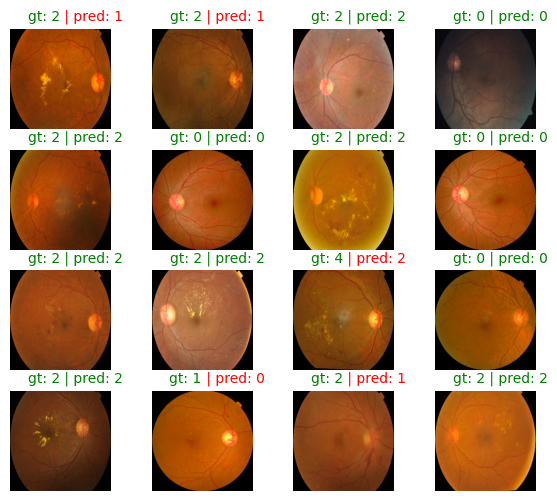

In [ ]:
gt, feat, id = get_random_samples(y_test_ef, X_test_ef, test_id_ef)

pred_ = rft.predict(feat)

plot_prediction(id, gt, pred_)

# Hist Gray

In [ ]:
(train_id_gr, X_train_gr, y_train_gr), (test_id_gr, X_test_gr, y_test_gr) = load_data('/content/drive/MyDrive/CS/datasets/histogram_grayscale/train_data.npy',
                                                                    '/content/drive/MyDrive/CS/datasets/histogram_grayscale/test_data.npy')

## SVC

In [ ]:
from sklearn.svm import SVC

svc = SVC(C=10, gamma= 'scale', kernel= 'rbf')
svc.fit(X_train_gr, y_train_gr)

SVC(C=10)

In [ ]:
preds = svc.predict(X_test_gr)
print(classification_report(y_test_gr, preds))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       542
           1       0.23      0.05      0.08       111
           2       0.52      0.86      0.65       300
           3       0.58      0.12      0.20        58
           4       0.50      0.01      0.02        88

    accuracy                           0.70      1099
   macro avg       0.54      0.39      0.37      1099
weighted avg       0.67      0.70      0.64      1099



<Axes: >

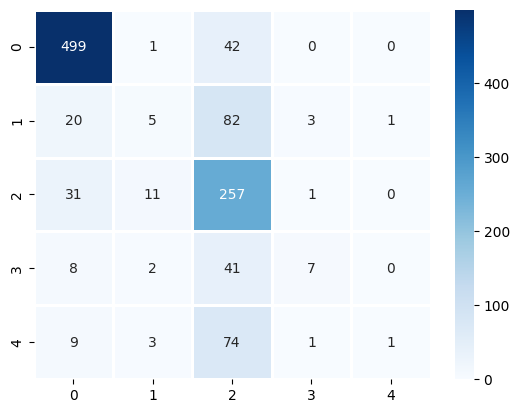

In [ ]:
sn.heatmap(confusion_matrix(y_test_gr, preds), cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')

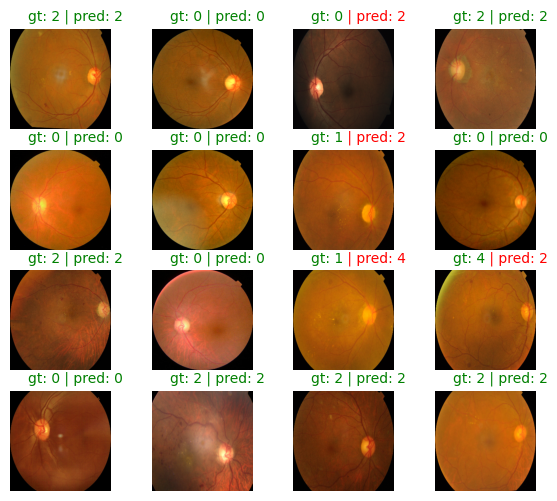

In [ ]:
gt, feat, id = get_random_samples(y_test_gr, X_test_gr, test_id_gr)

pred_ = svc.predict(feat)

plot_prediction(id, gt, pred_)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rft = RandomForestClassifier(criterion= 'entropy', max_depth= 25, =max_features None, n_estimators= 40)
rft.fit(X_train_gr, y_train_gr)

RandomForestClassifier()

In [ ]:
preds = rft.predict(X_test_gr)
print(classification_report(y_test_gr, preds))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       542
           1       0.48      0.14      0.22       111
           2       0.54      0.84      0.66       300
           3       0.50      0.09      0.15        58
           4       0.40      0.07      0.12        88

    accuracy                           0.71      1099
   macro avg       0.56      0.41      0.41      1099
weighted avg       0.68      0.71      0.66      1099



<Axes: >

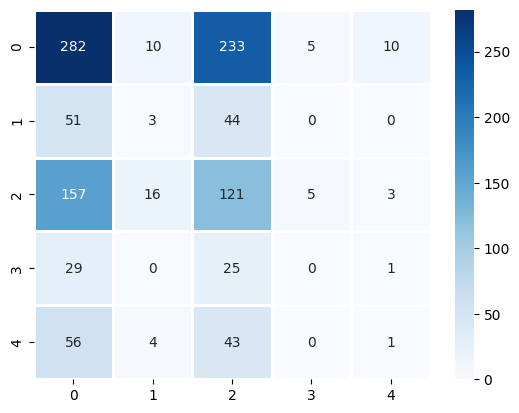

In [ ]:
sn.heatmap(confusion_matrix(y_test_ef, preds), cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')

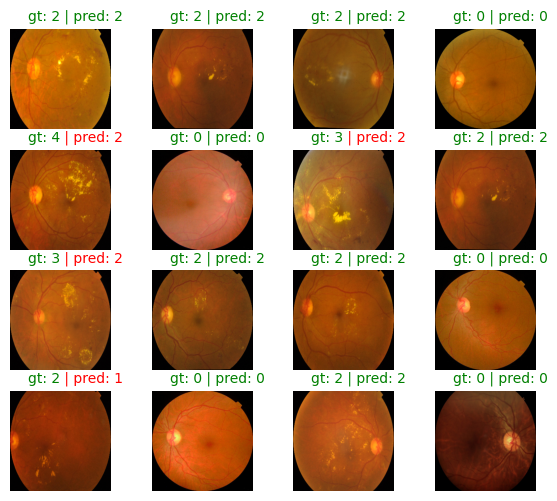

In [ ]:
gt, feat, id = get_random_samples(y_test_gr, X_test_gr, test_id_gr)

pred_ = rft.predict(feat)

plot_prediction(id, gt, pred_)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dct = DecisionTreeClassifier(criterion='log_loss', max_depth= 5, max_features= None, splitter= 'random')

dct.fit(X_train_gr, y_train_gr)

DecisionTreeClassifier(criterion='log_loss', max_depth=5, splitter='random')

In [ ]:
preds = dct.predict(X_test_gr)
print(classification_report(y_test_gr, preds))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       542
           1       0.00      0.00      0.00       111
           2       0.49      0.90      0.64       300
           3       0.00      0.00      0.00        58
           4       0.00      0.00      0.00        88

    accuracy                           0.68      1099
   macro avg       0.27      0.36      0.30      1099
weighted avg       0.56      0.68      0.61      1099



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

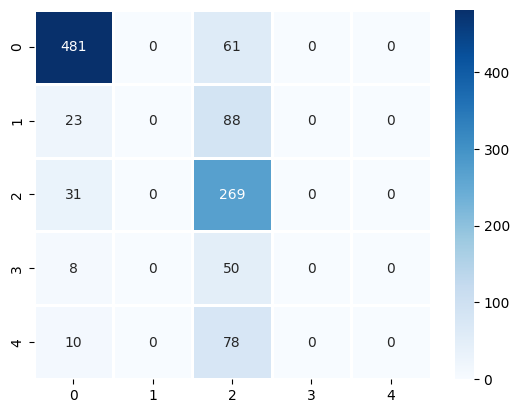

In [ ]:
sn.heatmap(confusion_matrix(y_test_gr, preds), cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')

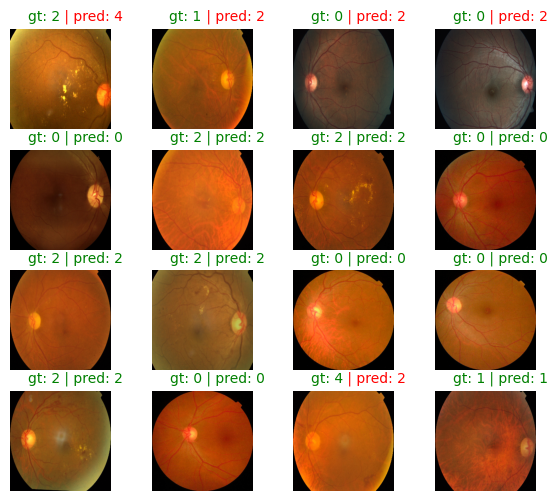

In [ ]:
gt, feat, id = get_random_samples(y_test_gr, X_test_gr, test_id_gr)

pred_ = rft.predict(feat)

plot_prediction(id, gt, pred_)

# Hist RBG

In [ ]:
(train_id_rgb, X_train_rgb, y_train_rgb), (test_id_rgb, X_test_rgb, y_test_rgb) = load_data('/content/drive/MyDrive/CS/datasets/histogram_rgb/train_data.npy',
                                                                    '/content/drive/MyDrive/CS/datasets/histogram_rgb/test_data.npy')

## SVC*

In [ ]:
from sklearn.svm import SVC

svc = SVC(C=10, gamma= 'scale', kernel= 'rbf')
svc.fit(X_train_rgb, y_train_rgb)

SVC(C=10)

In [ ]:
preds = svc.predict(X_test_rgb)
print(classification_report(y_test_rgb, preds))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       542
           1       0.40      0.26      0.32       111
           2       0.55      0.84      0.67       300
           3       0.62      0.14      0.23        58
           4       0.00      0.00      0.00        88

    accuracy                           0.73      1099
   macro avg       0.50      0.44      0.43      1099
weighted avg       0.67      0.73      0.68      1099



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

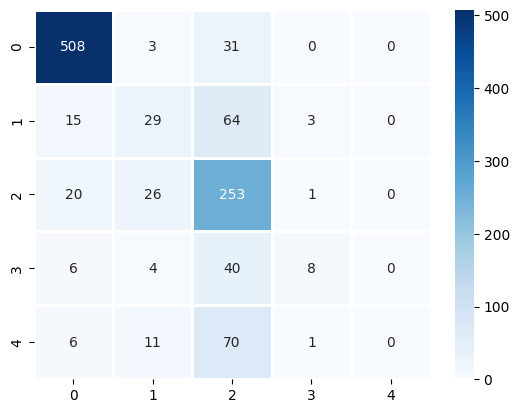

In [ ]:
sn.heatmap(confusion_matrix(y_test_gr, preds), cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')

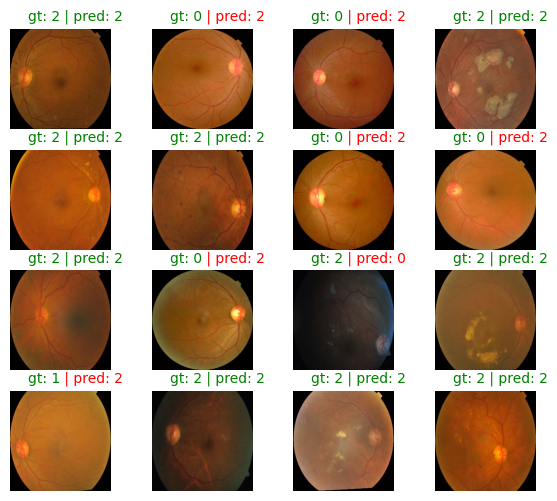

In [ ]:
gt, feat, id = get_random_samples(y_test_gr, X_test_gr, test_id_gr)

pred_ = svc.predict(feat)

plot_prediction(id, gt, pred_)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rft = RandomForestClassifier(criterion= 'log_loss', max_depth= None, max_features= None, n_estimators= 30)
rft.fit(X_train_rgb, y_train_rgb)

RandomForestClassifier(criterion='log_loss', max_features=None, n_estimators=30)

In [ ]:
preds = rft.predict(X_test_rgb)
print(classification_report(y_test_rgb, preds))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       542
           1       0.37      0.32      0.34       111
           2       0.58      0.79      0.67       300
           3       0.32      0.10      0.16        58
           4       0.57      0.15      0.23        88

    accuracy                           0.73      1099
   macro avg       0.55      0.46      0.47      1099
weighted avg       0.71      0.73      0.70      1099



<Axes: >

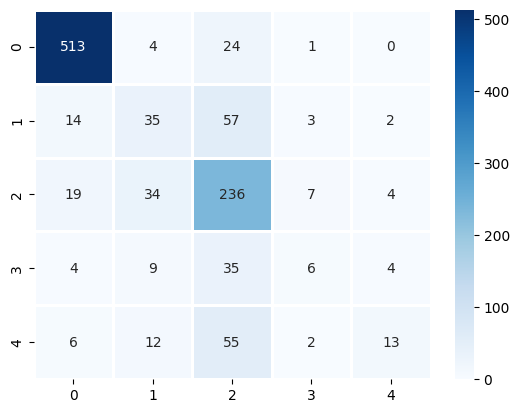

In [ ]:
sn.heatmap(confusion_matrix(y_test_rgb, preds), cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')

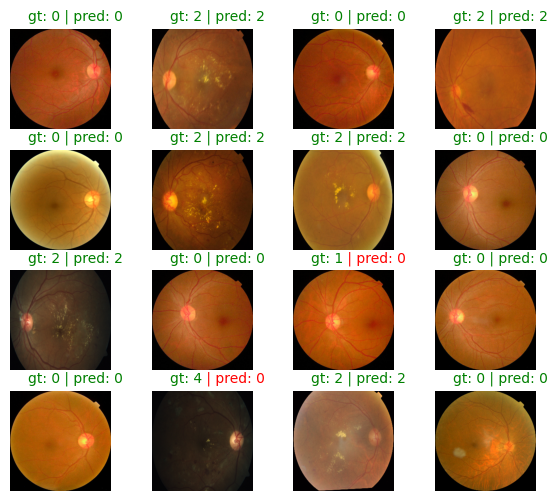

In [ ]:
gt, feat, id = get_random_samples(y_test_rgb, X_test_rgb, test_id_rgb)

pred_ = rft.predict(feat)

plot_prediction(id, gt, pred_)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dct = DecisionTreeClassifier(criterion='log_loss', max_depth= 5, max_features= None, splitter= 'best')

dct.fit(X_train_rgb, y_train_rgb)

DecisionTreeClassifier(criterion='log_loss', max_depth=5)

In [ ]:
preds = dct.predict(X_test_rgb)
print(classification_report(y_test_rgb, preds))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       542
           1       0.33      0.27      0.30       111
           2       0.56      0.79      0.66       300
           3       0.46      0.19      0.27        58
           4       0.00      0.00      0.00        88

    accuracy                           0.71      1099
   macro avg       0.45      0.44      0.43      1099
weighted avg       0.66      0.71      0.68      1099



<Axes: >

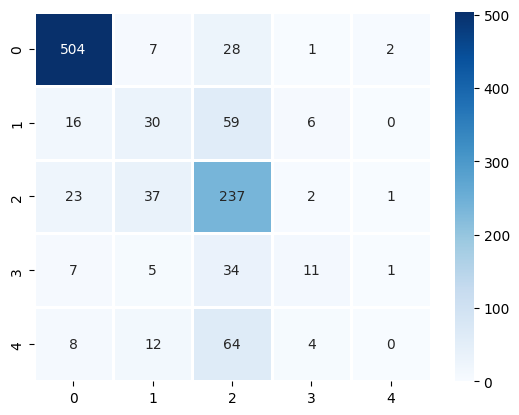

In [ ]:
sn.heatmap(confusion_matrix(y_test_rgb, preds), cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')

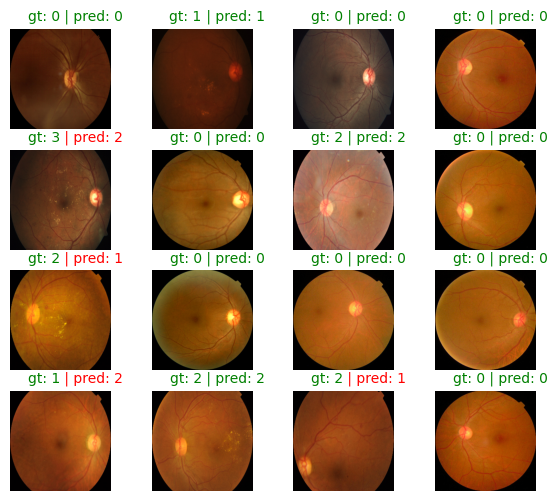

In [ ]:
gt, feat, id = get_random_samples(y_test_rgb, X_test_rgb, test_id_rgb)

pred_ = rft.predict(feat)

plot_prediction(id, gt, pred_)